обучение PINN
Эпоха 0: Total Loss = 1.800113
         Equation Loss = 0.122938
         Initial Loss = 0.931764
Эпоха 500: Total Loss = 0.168183
         Equation Loss = 0.164971
         Initial Loss = 0.001785
Эпоха 1000: Total Loss = 0.163104
         Equation Loss = 0.159723
         Initial Loss = 0.001878
Эпоха 1500: Total Loss = 0.159112
         Equation Loss = 0.156795
         Initial Loss = 0.001287
Эпоха 2000: Total Loss = 0.154914
         Equation Loss = 0.153948
         Initial Loss = 0.000537
Эпоха 2500: Total Loss = 0.101626
         Equation Loss = 0.101343
         Initial Loss = 0.000158
Эпоха 3000: Total Loss = 0.098119
         Equation Loss = 0.097800
         Initial Loss = 0.000177
Эпоха 3500: Total Loss = 0.094622
         Equation Loss = 0.094308
         Initial Loss = 0.000174
Эпоха 4000: Total Loss = 0.085659
         Equation Loss = 0.085395
         Initial Loss = 0.000147
Эпоха 4500: Total Loss = 0.071906
         Equation Loss = 0.071495
         Init

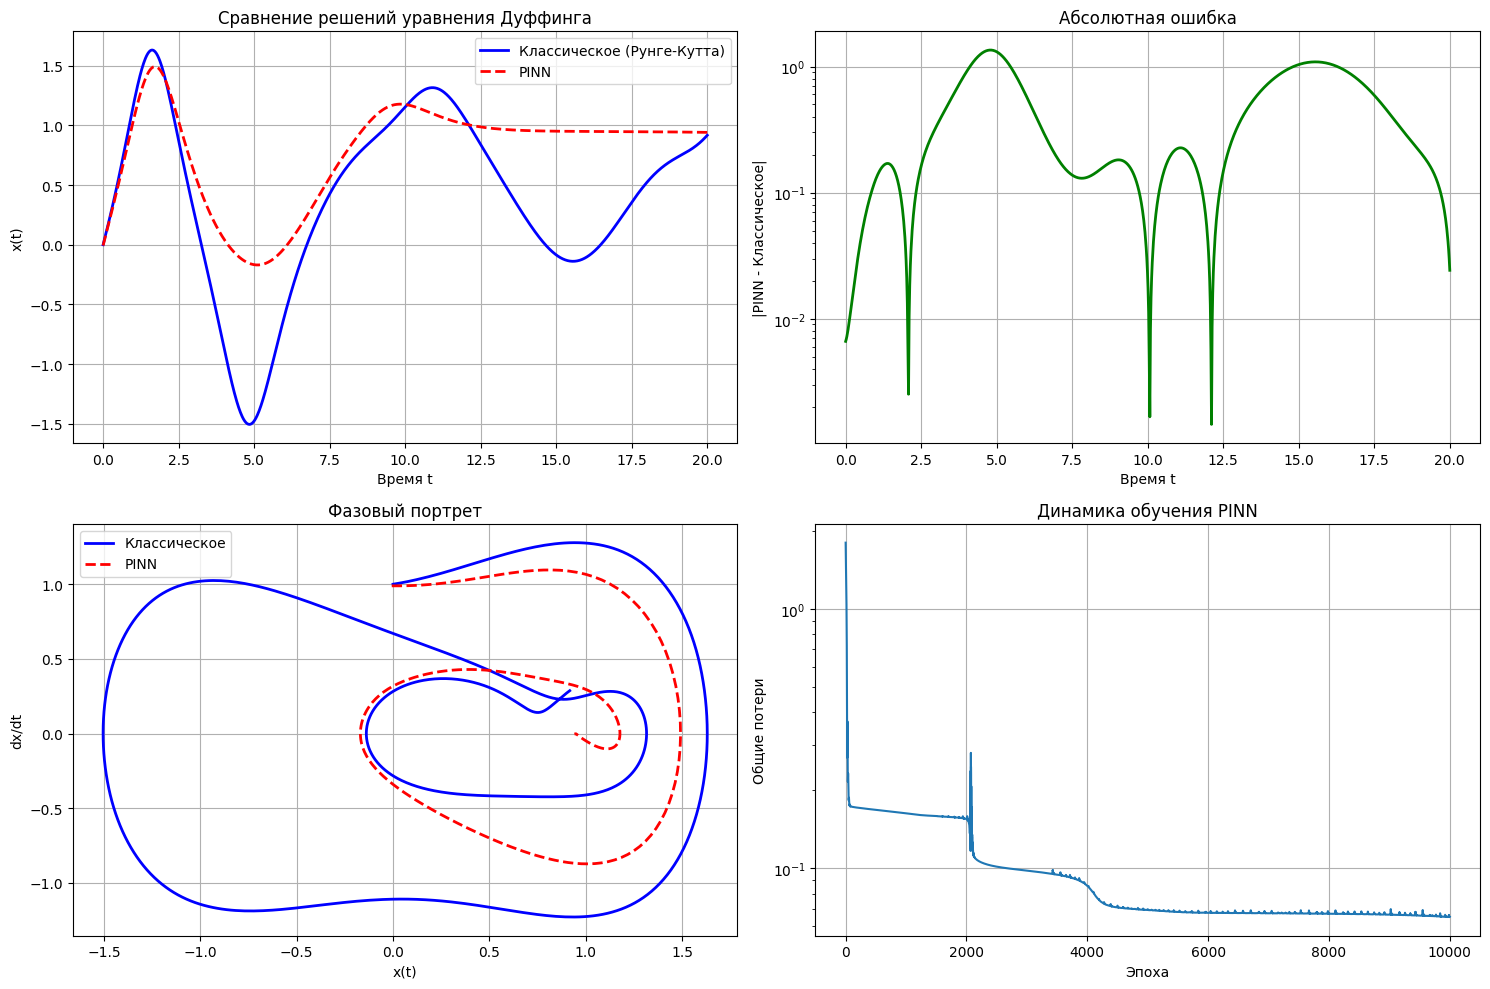

Средняя ошибка: 0.439176
Максимальная ошибка: 1.350477
Стандартное отклонение ошибки: 0.382896
ИССЛЕДОВАНИЕ ВЛИЯНИЯ ПАРАМЕТРОВ:
δ (демпфирование) = 0.3
α (линейная жесткость) = -1.0
β (нелинейная жесткость) = 1.0
γ (амплитуда силы) = 0.5
ω (частота силы) = 1.2


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

delta = 0.3    # коэффициент демпфирования
alpha = -1.0   # линейная жесткость
beta = 1.0     # нелинейная жесткость
gamma = 0.5    # амплитуда внешней силы
omega = 1.2    # частота внешней силы

# Начальные условия
x0 = 0.0       # начальное положение
v0 = 1.0       # начальная скорость

# Временной интервал
t_start, t_end = 0.0, 20.0
n_points = 1000

class DuffingNet(nn.Module):
    def __init__(self, hidden_size=128, num_layers=5):
        super().__init__()
        layers = []
        layers.append(nn.Linear(1, hidden_size))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

def calculate_duffing_loss(model, t_points, x0, v0):
    t = t_points.requires_grad_(True)

    x_pred = model(t)

    dx_dt = torch.autograd.grad(x_pred, t,
                               grad_outputs=torch.ones_like(x_pred),
                               create_graph=True)[0]

    d2x_dt2 = torch.autograd.grad(dx_dt, t,
                                 grad_outputs=torch.ones_like(dx_dt),
                                 create_graph=True)[0]

    residual = d2x_dt2 + delta*dx_dt + alpha*x_pred + beta*x_pred**3 - gamma*torch.cos(omega*t)

    loss_equation = (residual ** 2).mean()

    t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    x_pred_0 = model(t0)
    dx_dt_0 = torch.autograd.grad(x_pred_0, t0,
                                 grad_outputs=torch.ones_like(x_pred_0),
                                 create_graph=True)[0]

    loss_initial = (x_pred_0 - x0)**2 + (dx_dt_0 - v0)**2

    total_loss = 1 * loss_equation + 1.8 * loss_initial #уменьшим вес начального условия для уменьшения потерь на уравнении
    return total_loss, loss_equation, loss_initial

def duffing_ode(t, y):
    x, v = y
    dx_dt = v
    dv_dt = -delta*v - alpha*x - beta*x**3 + gamma*np.cos(omega*t)
    return [dx_dt, dv_dt]

t_span = [t_start, t_end]
y0 = [x0, v0]
t_eval = np.linspace(t_start, t_end, n_points)
solution = solve_ivp(duffing_ode, t_span, y0, t_eval=t_eval, method='RK45')
t_classical = solution.t
x_classical = solution.y[0]

model = DuffingNet(hidden_size=128, num_layers=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
t_points = torch.linspace(t_start, t_end, n_points).unsqueeze(1)

print("обучение PINN")

loss_history = []
for epoch in range(10001):
    optimizer.zero_grad()

    total_loss, loss_eq, loss_ic = calculate_duffing_loss(model, t_points, x0, v0)

    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Эпоха {epoch}: Total Loss = {total_loss.item():.6f}")
        print(f"         Equation Loss = {loss_eq.item():.6f}")
        print(f"         Initial Loss = {loss_ic.item():.6f}")

print("Обучение завершено")

# Предсказание PINN
with torch.no_grad():
    t_test = torch.linspace(t_start, t_end, 1000).unsqueeze(1)
    x_pinn = model(t_test).numpy()

# Графики
plt.figure(figsize=(15, 10))

# График 1: Сравнение решений
plt.subplot(2, 2, 1)
plt.plot(t_classical, x_classical, 'b-', linewidth=2, label='Классическое (Рунге-Кутта)')
plt.plot(t_test.numpy(), x_pinn, 'r--', linewidth=2, label='PINN')
plt.xlabel('Время t')
plt.ylabel('x(t)')
plt.title('Сравнение решений уравнения Дуффинга')
plt.legend()
plt.grid(True)

# График 2: Ошибка
plt.subplot(2, 2, 2)
# Интерполируем PINN решение на точки классического метода
t_interp = torch.tensor(t_classical).unsqueeze(1).float()
with torch.no_grad():
    x_pinn_interp = model(t_interp).numpy()
error = np.abs(x_classical - x_pinn_interp.flatten())
plt.plot(t_classical, error, 'g-', linewidth=2)
plt.xlabel('Время t')
plt.ylabel('|PINN - Классическое|')
plt.title('Абсолютная ошибка')
plt.grid(True)
plt.yscale('log')

# График 3: Фазовый портрет
plt.subplot(2, 2, 3)
# Вычисляем скорость для PINN
t_phase = torch.linspace(t_start, t_end, 500).unsqueeze(1).requires_grad_(True)
x_phase = model(t_phase)
dx_dt_phase = torch.autograd.grad(x_phase, t_phase,
                                 grad_outputs=torch.ones_like(x_phase),
                                 create_graph=True)[0]

with torch.no_grad():
    plt.plot(x_classical, solution.y[1], 'b-', linewidth=2, label='Классическое')
    plt.plot(x_phase.numpy(), dx_dt_phase.numpy(), 'r--', linewidth=2, label='PINN')
plt.xlabel('x(t)')
plt.ylabel('dx/dt')
plt.title('Фазовый портрет')
plt.legend()
plt.grid(True)

# График 4: Динамика обучения
plt.subplot(2, 2, 4)
plt.plot(loss_history)
plt.xlabel('Эпоха')
plt.ylabel('Общие потери')
plt.title('Динамика обучения PINN')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()


print(f"Средняя ошибка: {np.mean(error):.6f}")
print(f"Максимальная ошибка: {np.max(error):.6f}")
print(f"Стандартное отклонение ошибки: {np.std(error):.6f}")




